In [299]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [300]:
# read csv into df
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from constants import *
from glob import glob
from datetime import datetime
import os


df = pd.DataFrame(columns=['datum', "location_id", "pretocnost"])

location_dict = {
    "kum": 0,
    "lovrenška_jezera": 1,
    "osp": 2,
    "storžič": 3,
    "triglavski_narodni_park": 4,
    "vršič": 5,
}

for path in glob(DATA_GLOB_PLANINSKE_MAKRO_ALL):
    print(path)

    # get file name without extension and path
    file_name = os.path.basename(path).split('.')[0].lower().replace(" ", "_")
    if file_name == "zdruzeno":
        continue
    
    # file_name = path.split('/')[-1].split('.')[0].replace(" ", "_").lower()
    assert file_name in location_dict.keys(), f"file_name = {file_name}"
    print(file_name)
    location_id = location_dict[file_name]

    df_planine = pd.read_csv(path, sep=',', encoding='UTF-8')
    assert df_planine.columns[0] == 'datum', f"columns[0] = {df_planine.columns[0]}"
    assert df_planine.columns[1] == 'vhodi', f"columns[1] = {df_planine.columns[1]}"
    assert df_planine.columns[2] == 'izhodi', f"columns[2] = {df_planine.columns[2]}"
    
    # sum vhodi and izhodi
    df_planine['pretocnost'] = df_planine['vhodi'] + df_planine['izhodi']
    # drop "vhodi" and "izhodi" columns
    df_planine = df_planine.drop(columns=['vhodi', 'izhodi'])

    # add "location_id" column
    df_planine['location_id'] = location_id

    df = pd.concat([df, df_planine], ignore_index=True)

    # sum vhodi and izhodi based on "datum_dan"
    # df_planine = df_planine.groupby('datum').sum()
    print(df_planine.head())

    
    # break

df = df.sort_values(by=['datum', 'location_id'])
print(df.head())

df.to_csv(OUT_PLANINSTVO, index=False)



../data/planinstvo/2024\Kum.csv
kum
        datum  pretocnost  location_id
0  2022-06-20           3            0
1  2022-06-21          24            0
2  2022-06-22           3            0
3  2022-06-23           5            0
4  2022-06-24           8            0
../data/planinstvo/2024\Lovrenška jezera.csv
lovrenška_jezera
        datum  pretocnost  location_id
0  2022-06-27         318            1
1  2022-06-28          66            1
2  2022-06-29         214            1
3  2022-06-30         288            1
4  2022-07-01         379            1
../data/planinstvo/2024\Osp.csv
osp
        datum  pretocnost  location_id
0  2022-06-15          46            2
1  2022-06-16          60            2
2  2022-06-17          79            2
3  2022-06-18          62            2
4  2022-06-19          40            2
../data/planinstvo/2024\Storžič.csv
storžič
        datum  pretocnost  location_id
0  2022-07-19          72            3
1  2022-07-20         144            3
2  

## Add day of week to the data

In [301]:
import datetime

# convert datum to day of the week number with Monday=0, Sunday=6
df['datum'] = pd.to_datetime(df['datum'])
df['day_of_week'] = df['datum'].dt.dayofweek

# 

print(df.head())

          datum location_id pretocnost  day_of_week
2251 2022-06-01           4       1288            2
2252 2022-06-02           4        743            3
2253 2022-06-03           4       1128            4
2254 2022-06-04           4       2488            5
2255 2022-06-05           4       2466            6


## Add is holiday to the data

In [302]:
df_prazniki = pd.read_csv(OUT_PRAZNIKI)

# based on datum column from df add "praznik" column from df_prazniki. join based on "datum" column that is only the date without time
df_prazniki['datum'] = pd.to_datetime(df_prazniki['datum'])
df['datum'] = pd.to_datetime(df['datum'])
df_prazniki['datum'] = df_prazniki['datum'].dt.date
df['datum'] = df['datum'].dt.date
df_new = pd.merge(df, df_prazniki, on='datum', how='left') 

# fill NaN values in "dela_prost_dan" column with False
df_new['dela_prost_dan'] = df_new['dela_prost_dan'].fillna(False)

# # set dela_prost_dan to True if day_of_week is 5 or 6
# df_new['dela_prost_dan'] = df_new['dela_prost_dan'] | (df_new['day_of_week'] >= 5)

df_new

,datum,location_id,pretocnost,day_of_week,dela_prost_dan
0,2022-06-01,4,1288,2,False
1,2022-06-02,4,743,3,False
2,2022-06-03,4,1128,4,False
3,2022-06-04,4,2488,5,False
4,2022-06-05,4,2466,6,True
...,...,...,...,...,...
2857,2024-03-29,5,0,4,False
2858,2024-03-30,0,0,5,False
2859,2024-03-30,1,30,5,False
2860,2024-03-30,2,0,5,False


In [303]:
# sort by "location_id" and "datum"
df_new = df_new.sort_values(by=['location_id', 'datum'])
df_new

,datum,location_id,pretocnost,day_of_week,dela_prost_dan
24,2022-06-20,0,3,0,False
27,2022-06-21,0,24,1,False
30,2022-06-22,0,3,2,False
33,2022-06-23,0,5,3,False
36,2022-06-24,0,8,4,False
...,...,...,...,...,...
2845,2024-03-26,5,0,1,False
2849,2024-03-27,5,0,2,False
2853,2024-03-28,5,0,3,False
2857,2024-03-29,5,0,4,False


In [304]:
# add month column
df_new['month'] = pd.to_datetime(df_new['datum']).dt.month
df_new

,datum,location_id,pretocnost,day_of_week,dela_prost_dan,month
24,2022-06-20,0,3,0,False,6
27,2022-06-21,0,24,1,False,6
30,2022-06-22,0,3,2,False,6
33,2022-06-23,0,5,3,False,6
36,2022-06-24,0,8,4,False,6
...,...,...,...,...,...,...
2845,2024-03-26,5,0,1,False,3
2849,2024-03-27,5,0,2,False,3
2853,2024-03-28,5,0,3,False,3
2857,2024-03-29,5,0,4,False,3


In [305]:
# todo: add moving average by date for each location separately
df_new['pretocnost_7d'] = df_new.groupby('location_id')['pretocnost'].transform(lambda x: x.rolling(7, 1).mean())

df_new['pretocnost_3d'] = df_new.groupby('location_id')['pretocnost'].transform(lambda x: x.rolling(3, 1).mean())


In [306]:
# check if nan values are present in "pretocnost" column
df_new[df_new['pretocnost'].isnull()]

# make quantiles 3 bins group_by "location_id"
for location_id in df_new['location_id'].unique():
    num_quantiles = 3
    # get [.33, .66]
    quantile_list = [i/num_quantiles for i in range(1, num_quantiles)]
    # print(quantile_list)
    quantiles = df_new[df_new['location_id'] == location_id]['pretocnost'].quantile(quantile_list)
    bins = [-np.inf] + quantiles.to_list() + [np.inf]
    # print(bins)

    # cut based on quantiles
    df_new.loc[df_new['location_id'] == location_id, 'pretocnost_q'] = pd.cut(df_new[df_new['location_id'] == location_id]['pretocnost'], bins=bins, labels=False)

df_new['pretocnost_q'] = df_new['pretocnost_q'].astype(int)

# # drop pretocnost column
df_new = df_new.drop(columns=['pretocnost'])
df_new

,datum,location_id,day_of_week,dela_prost_dan,month,pretocnost_7d,pretocnost_3d,pretocnost_q
24,2022-06-20,0,0,False,6,3.00,3.000000,0
27,2022-06-21,0,1,False,6,13.50,13.500000,1
30,2022-06-22,0,2,False,6,10.00,10.000000,0
33,2022-06-23,0,3,False,6,8.75,10.666667,0
36,2022-06-24,0,4,False,6,8.60,5.333333,1
...,...,...,...,...,...,...,...,...
2845,2024-03-26,5,1,False,3,0.00,0.000000,0
2849,2024-03-27,5,2,False,3,0.00,0.000000,0
2853,2024-03-28,5,3,False,3,0.00,0.000000,0
2857,2024-03-29,5,4,False,3,0.00,0.000000,0


In [307]:
# save to csv
df_new.to_csv(OUT_PLANINSTVO_END, index=False)


In [308]:
# split data to train (2022 and 2023) and test (2024)
df_train = df_new[df_new['datum'] < datetime.date(2024, 1, 1)]
df_test = df_new[df_new['datum'] >= datetime.date(2024, 1, 1)]

df_test

#split train on train and validation 80/20 split
# train_df, val_df = df_train(df_train, test_size=0.2, random_state=42)


,datum,location_id,day_of_week,dela_prost_dan,month,pretocnost_7d,pretocnost_3d,pretocnost_q
2545,2024-01-01,0,0,True,1,57.857143,29.000000,1
2549,2024-01-02,0,1,True,1,89.571429,143.000000,2
2553,2024-01-03,0,2,False,1,82.142857,134.666667,0
2557,2024-01-04,0,3,False,1,80.142857,132.666667,1
2561,2024-01-05,0,4,False,1,70.285714,10.000000,1
...,...,...,...,...,...,...,...,...
2845,2024-03-26,5,1,False,3,0.000000,0.000000,0
2849,2024-03-27,5,2,False,3,0.000000,0.000000,0
2853,2024-03-28,5,3,False,3,0.000000,0.000000,0
2857,2024-03-29,5,4,False,3,0.000000,0.000000,0


In [309]:
# remove "datum" column
df_train = df_train.drop(columns=['datum'])


In [310]:
# start training a model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

X = df_train.drop(columns=['pretocnost_q'])
y = df_train['pretocnost_q']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

# print y_pred and y_val in dataframe
df_pred = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred})
# add X_val columns
df_pred = pd.concat([df_pred, X_val], axis=1)

mse = mean_squared_error(y_val, y_pred)
print(f"mse = {mse}")

# accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"accuracy = {accuracy}")

# precision and recall and f1 summary
print(classification_report(y_val, y_pred))

# print all wrong predictions
print("Number of wrong predictions: ", len(df_pred[df_pred['y_val'] != df_pred['y_pred']]))
print("Number of correct predictions: ", len(df_pred[df_pred['y_val'] == df_pred['y_pred']]))

df_pred[df_pred['y_val'] != df_pred['y_pred']]

# # save model
# import joblib
# joblib.dump(model, OUT_MODEL)


mse = 0.3143418467583497
accuracy = 0.7269155206286837
              precision    recall  f1-score   support

           0       0.73      0.72      0.72       130
           1       0.62      0.62      0.62       175
           2       0.82      0.82      0.82       204

    accuracy                           0.73       509
   macro avg       0.72      0.72      0.72       509
weighted avg       0.73      0.73      0.73       509

Number of wrong predictions:  139
Number of correct predictions:  370


,y_val,y_pred,location_id,day_of_week,dela_prost_dan,month,pretocnost_7d,pretocnost_3d
2073,1,0,1,1,False,9,37.714286,21.666667
2482,0,1,1,0,False,12,42.571429,36.000000
80,1,2,4,1,False,7,3175.142857,3954.000000
1805,0,1,3,3,False,8,70.285714,28.333333
708,1,0,3,5,False,10,83.714286,18.666667
...,...,...,...,...,...,...,...,...
1374,0,1,1,4,False,4,86.285714,14.000000
382,1,2,1,0,False,8,374.000000,408.000000
437,2,1,2,2,False,9,56.857143,60.333333
1242,0,1,1,6,False,2,15.857143,35.666667


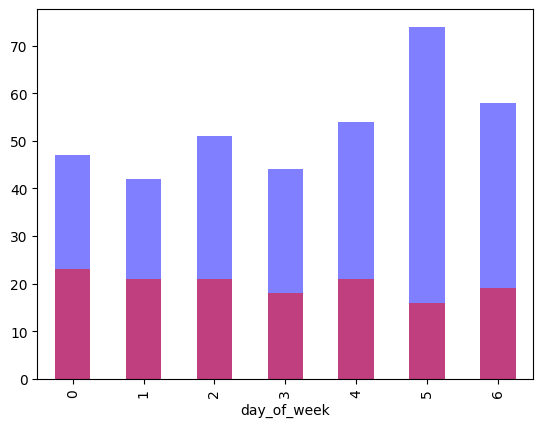

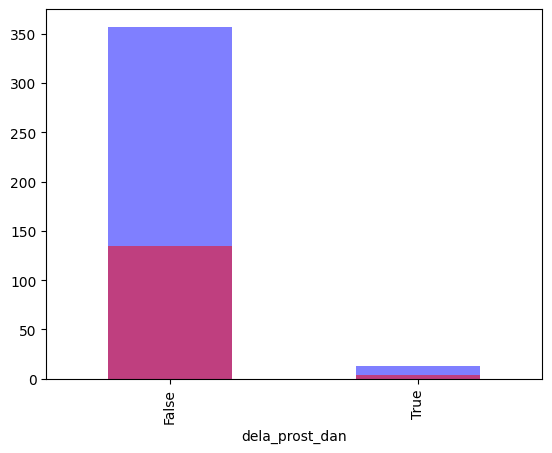

In [311]:
# visualize correct vs wrong predictions based on day_of_week
df_pred['correct'] = df_pred['y_val'] == df_pred['y_pred']
df_pred['wrong'] = df_pred['y_val'] != df_pred['y_pred']

df_pred.groupby('day_of_week')['correct'].sum().plot(kind='bar', color='blue', alpha=0.5)
df_pred.groupby('day_of_week')['wrong'].sum().plot(kind='bar', color='red', alpha=0.5)
plt.show()

# do the same for dela_prost_dan
df_pred.groupby('dela_prost_dan')['correct'].sum().plot(kind='bar', color='blue', alpha=0.5)
df_pred.groupby('dela_prost_dan')['wrong'].sum().plot(kind='bar', color='red', alpha=0.5)
plt.show()

In [315]:
# get correlation matrix
corr = df_train.corr()
corr.style.background_gradient(cmap='coolwarm')

,location_id,day_of_week,dela_prost_dan,month,pretocnost_7d,pretocnost_3d,pretocnost_q
location_id,1.000000,0.003618,-0.022804,0.225825,0.173762,0.157364,0.020253
day_of_week,0.003618,1.000000,-0.087877,0.015142,0.000262,0.004847,0.224034
dela_prost_dan,-0.022804,-0.087877,1.000000,-0.018575,0.005918,0.008295,0.107357
month,0.225825,0.015142,-0.018575,1.000000,0.012265,0.010051,-0.088852
pretocnost_7d,0.173762,0.000262,0.005918,0.012265,1.000000,0.904133,0.122686
pretocnost_3d,0.157364,0.004847,0.008295,0.010051,0.904133,1.000000,0.138674
pretocnost_q,0.020253,0.224034,0.107357,-0.088852,0.122686,0.138674,1.000000


In [314]:
# %pip install Jinja2

   ---------------------------------------- 0.0/133.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/133.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/133.2 kB ? eta -:--:--
   --------- ------------------------------ 30.7/133.2 kB ? eta -:--:--
   --------- ------------------------------ 30.7/133.2 kB ? eta -:--:--
   ----------- --------------------------- 41.0/133.2 kB 495.5 kB/s eta 0:00:01
   ----------------- --------------------- 61.4/133.2 kB 469.7 kB/s eta 0:00:01
   -------------------------- ------------ 92.2/133.2 kB 438.1 kB/s eta 0:00:01
   -------------------------------------- 133.2/133.2 kB 561.6 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
